In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, wasserstein_distance, probplot
from scipy.special import lambertw
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import time
import cirq, random, sympy
import tensorflow_quantum as tfq
import tensorflow as tf
from cirq.contrib.svg import SVGCircuit
from cirq.circuits import InsertStrategy
import pandas as pd 

2024-05-10 10:22:17.841936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2024-05-10 10:22:17.841978: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-10 10:22:20.240105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2024-05-10 10:22:20.240134: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-10 10:22:20.240152: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-filippoorlandi1-40gmail-2ecom): /proc/driver/nvidia/version does not exist
2

In [2]:
# Load the CSV file
#file_path = 'sp500.csv'
sp500 = pd.read_csv('^BVSP.csv')
sp500 = sp500.rename(columns={'Column_Name' : 'Close'})
sp500['Close'] = sp500['Close'].fillna(sp500['Close'].rolling(window=4, min_periods=1).mean())

# Display the first few rows of the dataframe
sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,17098.0,17408.0,16719.0,16930.0,16930.0,0.0
1,2000-01-04,16908.0,16908.0,15851.0,15851.0,15851.0,0.0
2,2000-01-05,15871.0,16302.0,15350.0,16245.0,16245.0,0.0
3,2000-01-06,16237.0,16499.0,15977.0,16107.0,16107.0,0.0
4,2000-01-07,16125.0,16449.0,16125.0,16309.0,16309.0,0.0


Brazilian Stock index shape (total days):  tf.Tensor([2306], shape=(1,), dtype=int32)
GPU Available: []
GPU Device: 


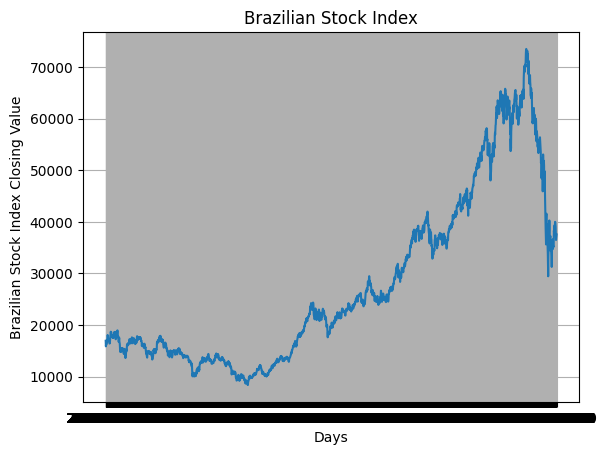

In [3]:
# pandas DataFrame with 6 columns, (Open, High, Low, Close, Adj Close, and Volume values)
# extract daily closing values as a numpy array
sp500_close = tf.convert_to_tensor(sp500['Close'].values)

# display the shape of the numpy array
print('Brazilian Stock index shape (total days): ', tf.shape(sp500_close))

# check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# check which GPU is being used
print("GPU Device:", tf.test.gpu_device_name())

df = sp500.reset_index()
date = df['Date']
# plot the S&P 500 data
plt.plot(date, sp500_close)
plt.xlabel('Days')
plt.ylabel('Brazilian Stock Index Closing Value')
plt.title('Brazilian Stock Index')
plt.grid()
plt.show()

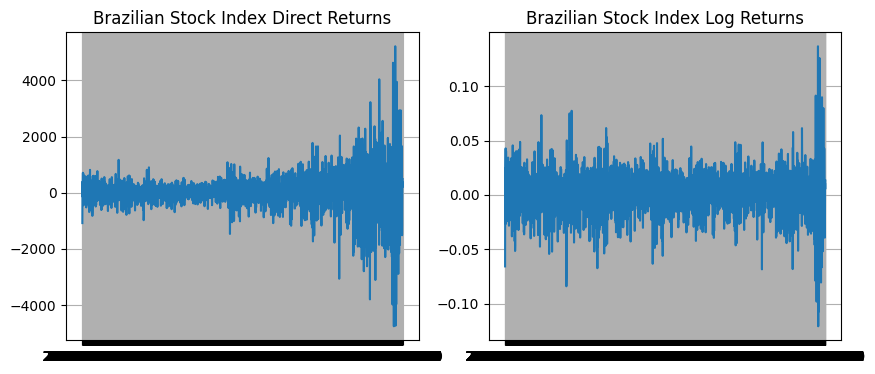

In [4]:
# direct returns over time
sp500_direct_r = sp500_close[1:] - sp500_close[:-1]

# logarithmic returns over time
sp500_log_r = np.log(sp500_close[1:]) - np.log(sp500_close[:-1])

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axes[0].plot(date[1:], sp500_direct_r)
axes[0].set_title('Brazilian Stock Index Direct Returns')
axes[0].grid()

axes[1].plot(date[1:], sp500_log_r)
axes[1].set_title('Brazilian Stock Index Log Returns')
axes[1].grid()

# Show the plot
plt.show()

In [5]:
df = pd.DataFrame(sp500_log_r)

# Save the DataFrame to a CSV file
csv_filename = 'original_log_br.csv'
df.to_csv(csv_filename, index=False)

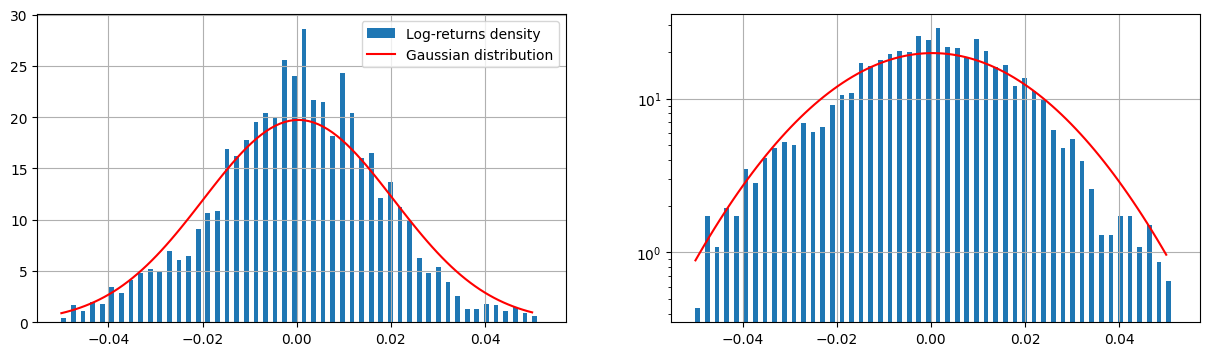

In [6]:
# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# density of log-returns
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(sp500_log_r, bins=bin_edges, density=True, width=0.001, label='Log-returns density')
axes[0].grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(sp500_log_r)
sigma = np.std(sp500_log_r)

# Generate a set of points x
x = np.linspace(-0.05, 0.05, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes[0].plot(x, pdf, 'r', label='Gaussian distribution')
axes[0].legend()

# plot in logarithmic scale
axes[1].hist(sp500_log_r, bins=bin_edges, density=True, width=0.001, log=True)
axes[1].grid()

# plot the Gaussian PDF in logarithmic scale
axes[1].semilogy(x, pdf, 'r')

plt.show()

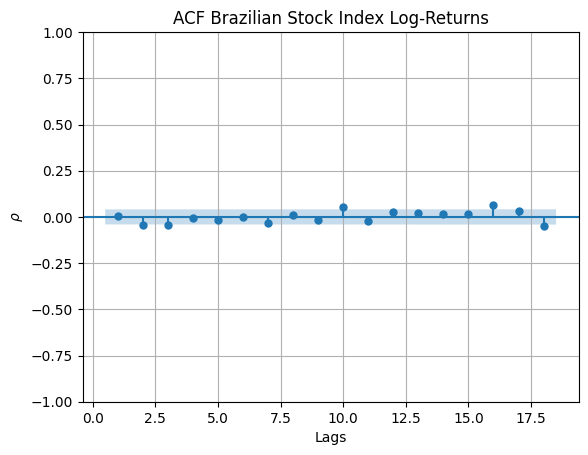

In [7]:
# convert the S&P 500 log returns to a TensorFlow tensor
sp500_log_r_tf = tf.convert_to_tensor(sp500_log_r)
# plot the ACF for the specified lags
tsaplots.plot_acf(sp500_log_r_tf, lags=18, zero=False)
plt.xlabel('Lags')
plt.title('ACF Brazilian Stock Index Log-Returns')
plt.ylabel(r'$\rho$')
plt.grid()
plt.show()

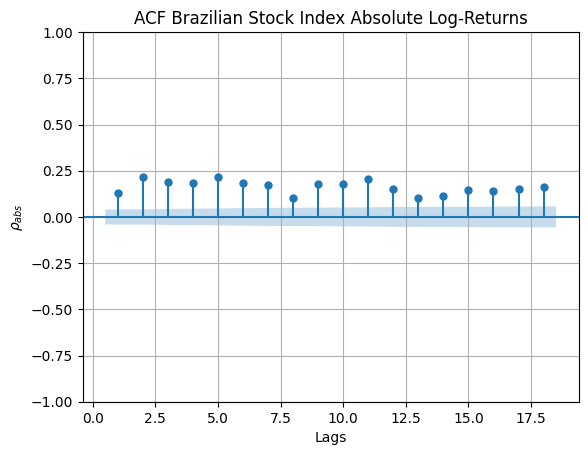

In [8]:
# plot the ACF of absolute log-returns for the specified lags
tsaplots.plot_acf(tf.abs(sp500_log_r_tf), lags=18, zero=False)
plt.xlabel('Lags')
plt.title('ACF Brazilian Stock Index Absolute Log-Returns')
plt.ylabel(r'$\rho_{abs}$')
plt.grid()
plt.show()

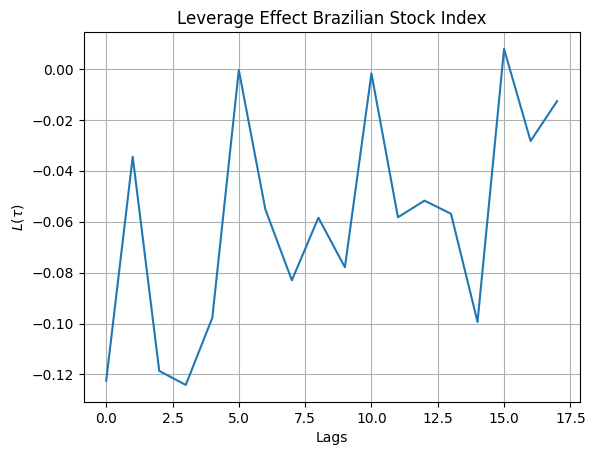

In [9]:
lags = range(1, 19)
lev = []
for lag in lags:
    # slice the tensors to get the appropriate lagged sequences
    r_t = sp500_log_r_tf[:-lag]
    squared_lag_r = tf.square(tf.abs(sp500_log_r_tf[lag:]))

    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    lev.append(correlation_matrix[0, 1])

# plot the the levarage effect
plt.plot(lev)
plt.title('Leverage Effect Brazilian Stock Index')
plt.xlabel('Lags')
plt.ylabel(r'$L(\tau)$')
plt.grid()
plt.show()

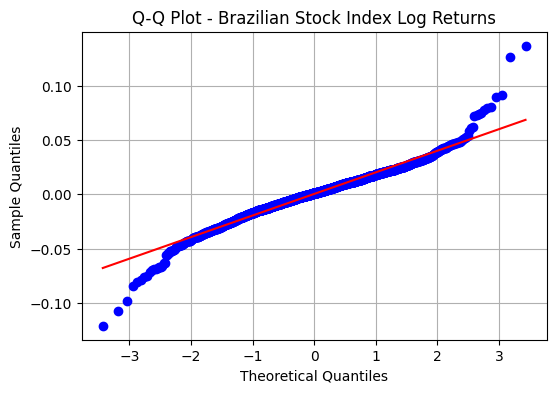

In [10]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(sp500_log_r_tf, dist='norm', plot=plt)
plt.title('Q-Q Plot - Brazilian Stock Index Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [11]:
def normalize(data):
    mu = tf.reduce_mean(data)
    std = tf.math.reduce_std(data)

    return (data - mu)/std

In [12]:
def denormalize(norm_data, mu_original, std_original):
    return norm_data*std_original + mu_original

In [13]:
# normalize the log-returns
sp500_norm_r = normalize(sp500_log_r_tf)
# display the mean and standard deviation of the original log-returns
print(f'Original S&P 500 log-returns mean = {tf.reduce_mean(sp500_log_r_tf)}, std = {tf.math.reduce_std(sp500_log_r_tf)}')
# display the mean and standard deviation of the normalized log-returns
print(f'Normalized S&P 500 log-returns mean = {tf.reduce_mean(sp500_norm_r)}, std = {tf.math.reduce_std(sp500_norm_r)}')

Original S&P 500 log-returns mean = 0.00034559053451848097, std = 0.02021461724292486
Normalized S&P 500 log-returns mean = 7.802868980011946e-18, std = 0.9999999999999998


In [14]:
print('Original Data Min-Max')
print(tf.reduce_min(sp500_log_r_tf).numpy(), tf.reduce_max(sp500_log_r_tf).numpy())

print('Normalized Data Min-Max')
print(tf.reduce_min(sp500_norm_r).numpy(), tf.reduce_max(sp500_norm_r).numpy())

Original Data Min-Max
-0.12096051469072933 0.13676611594662091
Normalized Data Min-Max
-6.00091031986792 6.748607889662108


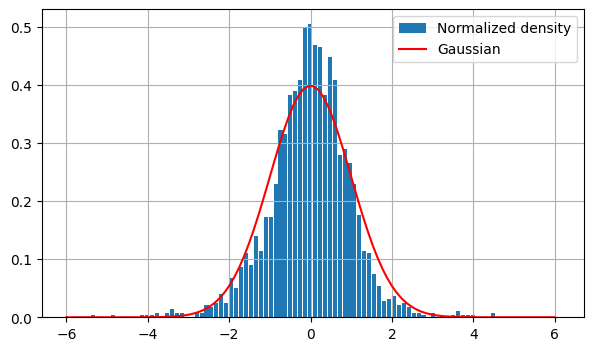

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of log-returns
bin_edges = np.linspace(-6, 6, num=100)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes.hist(sp500_norm_r, bins=bin_edges, density=True, width=0.1, label='Normalized density')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(sp500_norm_r)
sigma = np.std(sp500_norm_r)

# Generate a set of points x
x = np.linspace(-6, 6, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

In [16]:
def inverse_lambert_w_transform(data, delta):
    """
    Apply inverse Lambert W transform to the input data using the specified delta value.

    Parameters:
    - data: Input data tensor
    - delta: Delta value for the transform (tail parameter)

    Returns:
    - Transformed data array
    """
    sign = tf.sign(tf.cast(data, dtype=tf.float64))
    transformed_data = sign * tf.cast(tf.sqrt(lambertw(delta * data ** 2).real / delta), dtype=tf.float64)

    return transformed_data

def lambert_w_transform(transformed_data, delta, clip_low=-12.0, clip_high=11.0):
    """
    Transform the Gaussianized data back to its original state.

    Parameters:
    - transformed_data: Input data array which was transformed using inverse Lambert W
    - delta: Delta value for the transform (tail parameter)

    Returns:
    - Original Data
    """
    reversed_data = transformed_data*tf.cast(tf.exp((delta/2) * transformed_data ** 2), dtype=tf.float64)
    return tf.clip_by_value(reversed_data, clip_low, clip_high)

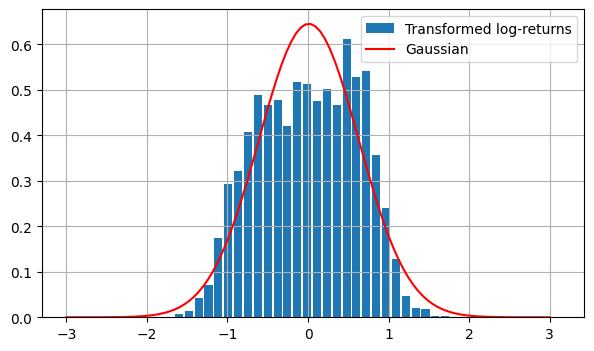

In [17]:
# apply inverse Lambert W transform to the normalized log-returns
delta = 1
transformed_sp500 = inverse_lambert_w_transform(sp500_norm_r, delta)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of normalized log-returns
bin_edges = np.linspace(-3, 3, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes.hist(transformed_sp500, bins=bin_edges, density=True, width=0.1, label='Transformed log-returns')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(transformed_sp500)
sigma = np.std(transformed_sp500)

# Generate a set of points x
x = np.linspace(-3, 3, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the normalized log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

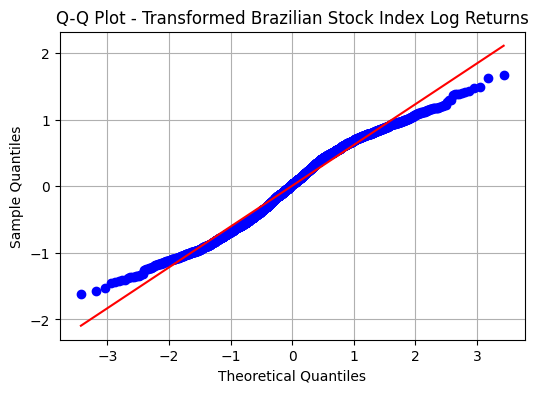

In [18]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(transformed_sp500, dist='norm', plot=plt)
plt.title('Q-Q Plot - Transformed Brazilian Stock Index Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [19]:
print('Transformed Data Min-Max')
print(tf.reduce_min(transformed_sp500).numpy(), tf.reduce_max(transformed_sp500).numpy())

Transformed Data Min-Max
-1.6187862840106004 1.6709090053684392


In [20]:
print('Transformed data mean: ', tf.reduce_mean(transformed_sp500).numpy())
print('Transformed data std: ', tf.math.reduce_std(transformed_sp500).numpy())

Transformed data mean:  0.009783749365906454
Transformed data std:  0.6180737038130942


In [21]:
min_val = tf.reduce_min(transformed_sp500)
max_val = tf.reduce_max(transformed_sp500)
scaled_data = -1.0 + 2.0 * (transformed_sp500 - min_val) / (max_val - min_val)

In [22]:
print(f'Scaled Normalized Transformed log-returns mean = {tf.reduce_mean(scaled_data)}, std = {tf.math.reduce_std(scaled_data)}')
print('Scaled Normalized Transformed log-returns min-max: ', tf.reduce_min(scaled_data).numpy(), tf.reduce_max(scaled_data).numpy())

Scaled Normalized Transformed log-returns mean = -0.00989612099671736, std = 0.3757634974938735
Scaled Normalized Transformed log-returns min-max:  -1.0 1.0


In [23]:
# a function to scale back from [-1,1] to the previous range
def rescale(scaled_data, rescaled_data):
    min_val = tf.reduce_min(rescaled_data)
    previous_data = 0.5 * (scaled_data + 1.0) * (max_val - min_val) + min_val

    return previous_data

In [24]:
def rolling_window(data, m, s):
    return tf.map_fn(lambda i: data[i:i+m], tf.range(0, len(data) - m + 1, s), dtype=tf.float64)

In [25]:
#1parte
class qGAN(tf.keras.Model):

    def __init__(self, num_epochs, batch_size, window_length, n_critic, gp, num_layers, num_qubits):
        super(qGAN, self).__init__()

        # classical hyperparameters
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.window_length = window_length
        self.n_critic = n_critic
        self.gp = gp

        # quantum hyperparameters
        # one layer corresponds to a rotation and an entangling layer together
        self.num_layers = num_layers
        self.num_qubits = num_qubits

        # quantum circuit settings
        self.qubits = cirq.GridQubit.rect(1, num_qubits)
        # create the set of Pauli strings to measure -> {X1, Z1, X2, Z2, etc}
        # X1 means we measure the first qubit only with X, Z1 the first qubit only with Z and so on...
        self.measurements = []
        for qubit in self.qubits:
            self.measurements.append(cirq.X(qubit))
            self.measurements.append(cirq.Z(qubit))

        # number of parameters of the PQC and re-uploading layers
        self.num_params = self.count_params()

        # define the trainable parameters of the PQC main and re-uploading layers (trainable)
        self.params_pqc = [sympy.Symbol(f'theta{i}') for i in range(self.num_params)]

        # define the classical critic network (CNN)
        self.critic = self.define_critic_model(window_length)
        # define the quantum generator network (PQC)
        self.generator = self.define_generator_model()

        # monitoring purposes
        # average critic and generator losses for each epoch
        self.critic_loss_avg = []
        self.generator_loss_avg = []
        # Earth's mover distance (EMD) for each epoch
        self.emd_avg = []
        # stylized facts RMSEs for each epoch
        self.acf_avg = []
        self.vol_avg = []
        self.lev_avg = []
#2 parte
    ####################################################################################
    #
    # count the parameters of the quantum circuit
    #
    ####################################################################################
    def count_params(self):

        # rotation layer with Rx, Ry, Rz has 3N parameters, where N is the number of qubits
        # the entangling layer is not parameterized
        num_params_pqc = 3*self.num_qubits*self.num_layers

        # also, count the parameters of the re-uploading layer that is sandwiched between rotation-entangling layers
        # there is one re-uploading layer after each rotation-entangling layer with a parameterized Rx gate,
        # so the number of parameters is equal to the number of qubits for each re-uploading layer
        num_params_upload = self.num_layers*self.num_qubits

        # the last layer of the PQC is a rotation layer
        num_params_pqc += 3*self.num_qubits

        return num_params_pqc+num_params_upload

    ####################################################################################
    #
    # the classical critic model as a convolutional network
    #
    ####################################################################################
    def define_critic_model(self, window_length):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, input_shape=(window_length, 1), padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Flatten())

        model.add(tf.keras.layers.Dense(32, dtype=tf.float64))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        model.add(tf.keras.layers.Dropout(0.2))

        model.add(tf.keras.layers.Dense(1, dtype=tf.float64))

        return model

    ####################################################################################
    #
    # the encoding layer: resolve the parameters by uniform noise values,
    # used to prepare the initial state for the generator circuit
    #
    ####################################################################################
    def encoding_layer(self, noise_params):

        return cirq.Circuit(cirq.Rx(rads=noise_params[i])(self.qubits[i]) for i in range(self.num_qubits))

    ####################################################################################
    #
    # the quantum generator as a PQC with All-to-all topology for the entangling layer
    #
    ####################################################################################
    def define_generator_circuit(self):

        # cirq circuit
        pqc = cirq.Circuit()

        # index for the parameter tensor of the PQC main and re-uploading layers
        idx = 0
        for qubit in self.qubits:
            pqc.append(cirq.H(qubit))
        for layer in range(self.num_layers):
            ###############################################################
            #
            # single-qubit rotation layer
            #
            ###############################################################
            for qubit in self.qubits:
                ####################CAMBIO####################
                pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit))
                idx += 1
                pqc.append(cirq.Ry(rads=self.params_pqc[idx])(qubit))
                idx += 1
                #pqc.append(cirq.Rz(rads=self.params_pqc[idx])(qubit))
                #idx += 1

            ###############################################################
            #
            # entangling layer (not parameterized)
            #
            ###############################################################
            for qubit1 in range(self.num_qubits):
                for qubit2 in range(qubit1+1, self.num_qubits):
                    pqc.append(cirq.CNOT(self.qubits[qubit1], self.qubits[qubit2]), strategy=InsertStrategy.NEW)

            ###############################################################
            #
            # re-uploading layer with Rx rotation
            # (set the strategy for better readability and understanding)
            #
            ###############################################################
            for i, qubit in enumerate(self.qubits):
                if i == 0:
                    pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit), strategy=InsertStrategy.NEW)
                else:
                    pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit), strategy=InsertStrategy.INLINE)
                
                idx += 1

        #####################################################################
        #
        # single-qubit rotation layer as the last layer before measurement
        #
        #####################################################################
        for qubit in self.qubits:
                pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit))
                idx += 1
                pqc.append(cirq.Ry(rads=self.params_pqc[idx])(qubit))
                idx += 1
                #pqc.append(cirq.Rz(rads=self.params_pqc[idx])(qubit))
                #idx += 1

        return pqc

    ####################################################################################
    #
    # the quantum generator model
    #
    ####################################################################################
    def define_generator_model(self):
        # model input
        q_data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        # define the tensorflow quantum layer (trainable)
        generator = tfq.layers.PQC(self.define_generator_circuit(), self.measurements, repetitions=1000)
        generator_output = generator(q_data_input)
        # tensorflow model
        model = tf.keras.Model(inputs=q_data_input, outputs=generator_output)

        return model

    #############################################################################
    #
    # compile model with given optimizers for critic and generator networks
    #
    #############################################################################
    def compile_QGAN(self, c_optimizer, g_optimizer):
        super(qGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer

    def train_qgan(self, gan_data, original_data, preprocessed_data, num_elements):
        """
        Parameters:
         - gan_data is the preprocessed dataset with windows for qGAN training
         - original_data is the original S&P 500 log-returns for evaluation of RMSEs (monitoring purposes)
         - preprocessed_data is the preprocessed log-returns without the last normalization step and without windows
          (for reversing the process of generated samples using the mean and std and evaluating the RMSEs)
        """
        for epoch in range(self.num_epochs):
            print(f'Processing epoch {epoch+1}/{self.num_epochs}')
            ################################################################
            #
            # Train the critic for n_critic iterations
            # Process 'batch_size' samples in each iteration
            #
            ################################################################
            # critic loss for 'n_critic' iterations
            critic_t_sum = 0
            for t in range(self.n_critic):
                # record the gradients
                with tf.GradientTape() as critic_tape:
                    # critic loss for 'batch_size' samples
                    critic_sum = 0
                    for i in range(self.batch_size):
                        ###########################################
                        #
                        # Sample real data and a latent variable
                        #
                        ###########################################
                        # shuffle the dataset
                        shuffled_data = gan_data.shuffle(buffer_size=num_elements)
                        # take a single random element from the shuffled dataset
                        random_element = shuffled_data.take(1)
                        # iterate over the random_element dataset to access the value
                        for element in random_element:
                            # access the value of the random element as a tensor
                            real_sample = element
                        # reshape the real sample for compatibility with the first layer of the critic
                        real_sample = tf.reshape(real_sample, (1, self.window_length))

                        ##################################################
                        #
                        # Get the state prepared by the encoding circuit
                        #
                        ##################################################
                        # generate noise parameters for the encoding layer
                        noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
                        generator_input_state = self.encoding_layer(noise_values)
                        # convert to tensorflow quantum tensor
                        generator_input = tfq.convert_to_tensor([generator_input_state])
                        # get the fake sample as the expectations of the quantum circuit
                        generated_sample = self.generator(generator_input)
                        generated_sample = tf.cast(generated_sample, dtype=tf.float64)

                        # calculate the critic scores for real and fake samples
                        real_score = self.critic(real_sample)
                        fake_score = self.critic(generated_sample)

                        # compute the gradient penalty
                        gradient_penalty = self.compute_gradient_penalty(real_sample, generated_sample)

                        # calculate the Wasserstein distance loss with gradient penalty
                        critic_loss = fake_score - real_score + self.gp * gradient_penalty
                        # accumulate the critic loss for the sample
                        critic_sum += critic_loss

                    # compute the gradients of critic and apply them
                    critic_gradients = critic_tape.gradient(critic_sum/self.batch_size, self.critic.trainable_variables)
                    self.c_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

                    # accumulate the average critic loss for all samples in this 't' iteration
                    critic_t_sum += critic_sum/self.batch_size

            # average critic loss for this epoch of WGAN training
            self.critic_loss_avg.append(critic_t_sum/self.n_critic)

            ################################################################
            #
            # Train generator for one iteration
            #
            ################################################################
            # sample a batch of input states using the encoding layer
            input_circuits_batch = []
            for _ in range(self.batch_size):
                noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
                input_circuits_batch.append(self.encoding_layer(noise_values))

            # convert to tensorflow quantum tensor
            generator_inputs = tfq.convert_to_tensor(input_circuits_batch)

            with tf.GradientTape() as gen_tape:
                # generate fake samples using the generator
                generated_samples = self.generator(generator_inputs)
                generated_samples = tf.cast(generated_samples, dtype=tf.float64)
                # calculate the critic scores for fake samples
                fake_scores = self.critic(generated_samples)
                # calculate the generator loss
                generator_loss = -tf.reduce_mean(fake_scores)

            # compute the gradients of generator and apply them
            generator_gradients = gen_tape.gradient(generator_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))

            # average generator loss for this epoch
            self.generator_loss_avg.append(generator_loss)

            ########################################################################################################
            #
            # Calculate the stylized facts RMSEs and the EMD for real and fake data
            #
            # Fake data has shape (num_samples x window_length), with num_samples = original_length / window_length
            # in order to get a time series close to the length of the original
            #
            ########################################################################################################
            # generate noise
            num_samples = len(original_data) // self.window_length
            input_circuits_batch = []
            for _ in range(num_samples):
                noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
                input_circuits_batch.append(self.encoding_layer(noise_values))

            # convert to tensorflow quantum tensor
            generator_inputs = tfq.convert_to_tensor(input_circuits_batch)
            # generate fake samples using the generator
            batch_generated = self.generator(generator_inputs)
            # concatenate all time series data into one
            generated_data = tf.reshape(batch_generated, shape=(num_samples*self.window_length,))
            generated_data = tf.cast(generated_data, dtype=tf.float64)
            # rescale
            generated_data = rescale(generated_data, preprocessed_data)
            # reverse the preprocessing on generated sample
            original_norm = lambert_w_transform(generated_data, delta)
            fake_original = denormalize(original_norm, tf.reduce_mean(original_data), tf.math.reduce_std(original_data))
            # calculate the temporal metrics for monitoring the training process
            corr_rmse, volatility_rmse, lev_rmse, emd = self.stylized_facts(original_data, fake_original)
            # store the EMD and RMSEs of stylized facts
            self.acf_avg.append(corr_rmse)
            self.vol_avg.append(volatility_rmse)
            self.lev_avg.append(lev_rmse)
            self.emd_avg.append(emd)

            # print progress every 100 epochs
            if epoch % 100 == 0 or epoch+1 == 3000:
                print(f'\nEpoch {epoch+1} completed')
                print(f'Critic loss (average): {self.critic_loss_avg[epoch][-1][0]}')
                print(f'Generator loss (average): {self.generator_loss_avg[epoch]}')
                print(f'\nEMD (average): {self.emd_avg[epoch]}')
                print(f'ACF RMSE (average): {self.acf_avg[epoch]}')
                print(f'VOLATILITY RMSE (average): {self.vol_avg[epoch]}')
                print(f'LEVERAGE RMSE (average): {self.lev_avg[epoch]}\n')
                print('Min-Max values of original log-returns: ', tf.reduce_min(original_data).numpy(), tf.reduce_max(original_data).numpy())
                print('Min-Max values of generated log-returns (for all batches): ', tf.reduce_min(fake_original).numpy(), tf.reduce_max(fake_original).numpy())
                print('Min-Max values after Lambert: ', tf.reduce_min(original_norm).numpy(), tf.reduce_max(original_norm).numpy())
                print()

    ###########################################################
    #
    # Sample a random number epsilon ~ U[0,1]
    # Create a convex combination of real and generated sample
    # Compute the gradient penalty for the critic network
    #
    ###########################################################
    def compute_gradient_penalty(self, real_sample, generated_sample):
        epsilon = tf.random.uniform((), dtype=tf.float64)
        interpolated_sample = epsilon * real_sample + (1 - epsilon) * generated_sample

        with tf.GradientTape() as tape:
            tape.watch(interpolated_sample)
            scores = self.critic(interpolated_sample)

        gradients = tape.gradient(scores, interpolated_sample)
        gradients_norm = tf.norm(gradients)
        gradient_penalty = (gradients_norm - 1)**2

        return gradient_penalty

    def stylized_facts(self, original_data, fake_original):
        """
        - Calculate the RMSEs of the stylized facts between the original S&P 500 log-returns and
          generated time series

        - Evaluate the EMD between real and generated samples
        """

        ################################################
        #
        # stylized facts for fake samples
        #
        ################################################
        # compute acf for maximum lags = 18
        acf_values = sm.tsa.acf(fake_original, nlags=18)
        # exclude zero lag
        acf_values_generated = tf.convert_to_tensor(acf_values[1:])

        # compute absolute acf (volatility clustering) for maximum lags = 18
        acf_abs_values = sm.tsa.acf(tf.abs(fake_original), nlags=18)
        # exclude zero lag
        acf_abs_values_generated = tf.convert_to_tensor(acf_abs_values[1:])

        # compute leverage effect for maximum lags = 18
        lev = []
        for lag in range(1, 19):
            # slice the tensors to get the appropriate lagged sequences
            r_t = fake_original[:-lag]
            squared_lag_r = tf.square(tf.abs(fake_original[lag:]))

            # calculate the leverage effect
            # calculate the correlation coefficient
            correlation_matrix = np.corrcoef(r_t, squared_lag_r)
            lev.append(correlation_matrix[0, 1])

        leverage_generated = tf.convert_to_tensor(lev)

        ################################################
        #
        # stylized facts for real samples
        #
        ################################################

        # compute acf for maximum lags = 18
        acf_values = sm.tsa.acf(original_data, nlags=18)
        # exclude zero lag
        acf_values_original = tf.convert_to_tensor(acf_values[1:])

        # compute absolute acf (volatility clustering) for maximum lags = 18
        acf_abs_values = sm.tsa.acf(tf.abs(original_data), nlags=18)
        # exclude zero lag
        acf_abs_values_original = tf.convert_to_tensor(acf_abs_values[1:])

        # compute leverage effect for maximum lags = 18
        lev = []
        for lag in range(1, 19):
            # slice the tensors to get the appropriate lagged sequences
            r_t = original_data[:-lag]
            squared_lag_r = tf.square(tf.abs(original_data[lag:]))

            # calculate the leverage effect
            # calculate the correlation coefficient
            correlation_matrix = np.corrcoef(r_t, squared_lag_r)
            lev.append(correlation_matrix[0, 1])

        leverage_original = tf.convert_to_tensor(lev)

        # calculate average RMSEs of stylized facts
        # autocorrelations
        rmse_acf = tf.sqrt(tf.reduce_mean((acf_values_original-acf_values_generated)**2))
        # volatility clustering
        rmse_vol = tf.sqrt(tf.reduce_mean((acf_abs_values_original-acf_abs_values_generated)**2))
        # leverage effect
        rmse_lev = tf.sqrt(tf.reduce_mean((leverage_original-leverage_generated)**2))

        ####################################################################################
        #
        # compute the Earth's mover distance (EMD)
        #
        ####################################################################################
        bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
        bin_width = bin_edges[1] - bin_edges[0]
        bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
        # compute the empirical distribution of original data
        empirical_real, _ = np.histogram(original_data, bins=bin_edges, density=True)
        empirical_real /= np.sum(empirical_real)
        # compute the empirical distribution of generated data
        empirical_fake, _ = np.histogram(fake_original, bins=bin_edges, density=True)
        empirical_fake /= np.sum(empirical_fake)

        # evaluate the EMD using SciPy
        emd = wasserstein_distance(empirical_real, empirical_fake)

        return rmse_acf, rmse_vol, rmse_lev, emd

In [26]:
##################################################################
#
# Hyperparameters
#
##################################################################
WINDOW_LENGTH = 10  # this must be equal to the number of Pauli strings to measure
NUM_QUBITS = 5  # number of qubits
NUM_LAYERS = 3 # number of layers for the PQC

# training hyperparameters
EPOCHS = 2001
BATCH_SIZE = 20

n_critic = 2 # number of iterations for the critic per epoch
LAMBDA = 10  # gradient penalty strength

# instantiate the QGAN model object
qgan = qGAN(EPOCHS, BATCH_SIZE, WINDOW_LENGTH, n_critic, LAMBDA, NUM_LAYERS, NUM_QUBITS)

# set the optimizers
c_optimizer = tf.keras.optimizers.Adam()
g_optimizer = tf.keras.optimizers.Adam()
qgan.compile_QGAN(c_optimizer, g_optimizer)

##################################################################################
#
# Data pre-processing
#
##################################################################################
# apply rolling window in transformed (scaled) log-returns with stride s=2
gan_data_tf = rolling_window(scaled_data, WINDOW_LENGTH, 2)
# create TensorFlow datasets
gan_data = tf.data.Dataset.from_tensor_slices(gan_data_tf)
# get the number of elements in the dataset
num_elements = gan_data.cardinality().numpy()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

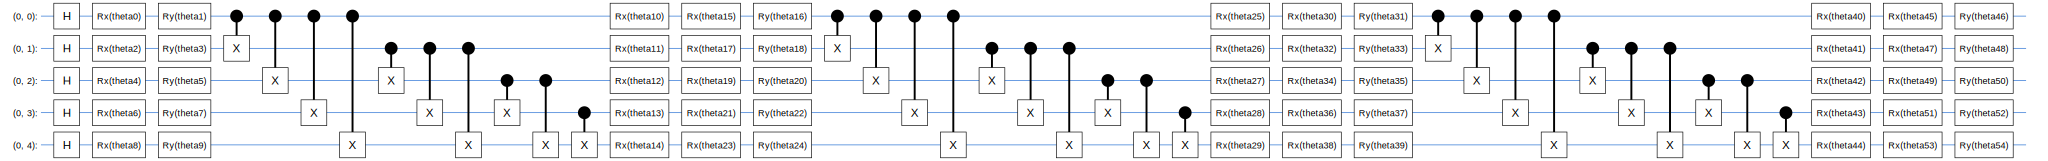

In [27]:
# display the generator circuit
SVGCircuit(qgan.define_generator_circuit())

In [28]:
# train the QGAN
print('Training started...')
print('Number of samples to process per epoch: ', num_elements)
print()
start_time_train = time.time()
model = qgan.train_qgan(gan_data, sp500_log_r_tf, transformed_sp500, num_elements)
exec_time_train = time.time() - start_time_train
print(f'\nQGAN training completed. Training time: --- {exec_time_train/3600:.02f} hours ---')


Training started...
Number of samples to process per epoch:  1148

Processing epoch 1/2001

Epoch 1 completed
Critic loss (average): 8.560244794518374
Generator loss (average): 0.027454938275259123

EMD (average): 0.01164020761861588
ACF RMSE (average): 0.042714199064882295
VOLATILITY RMSE (average): 0.15468851931073413
LEVERAGE RMSE (average): 0.07668194255609281

Min-Max values of original log-returns:  -0.12096051469072933 0.13676611594662091
Min-Max values of generated log-returns (for all batches):  -0.07911333101263264 0.10737073637295592
Min-Max values after Lambert:  -3.9307655738553167 5.2944433501898915

Processing epoch 2/2001
Processing epoch 3/2001
Processing epoch 4/2001
Processing epoch 5/2001
Processing epoch 6/2001
Processing epoch 7/2001
Processing epoch 8/2001
Processing epoch 9/2001
Processing epoch 10/2001
Processing epoch 11/2001
Processing epoch 12/2001
Processing epoch 13/2001
Processing epoch 14/2001
Processing epoch 15/2001
Processing epoch 16/2001
Processing 

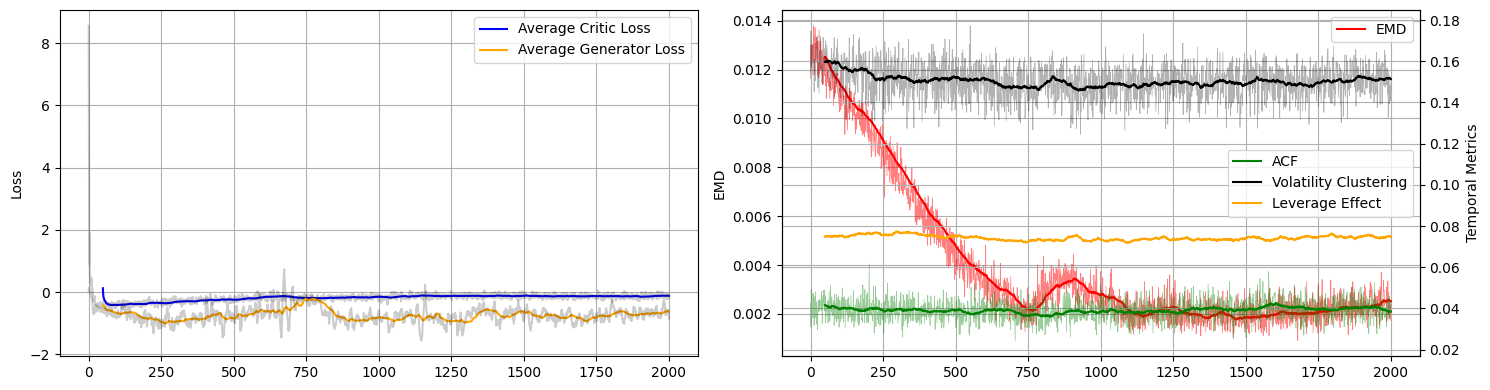

In [29]:
critic_loss = tf.squeeze(qgan.critic_loss_avg, axis=(1,2)).numpy()
generator_loss = np.array(qgan.generator_loss_avg)

window = 50
generator_ma = np.convolve(generator_loss, np.ones(window)/window, mode='valid')
critic_ma = np.convolve(critic_loss, np.ones(window)/window, mode='valid')

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# plot the critic loss moving average as a line
axes[0].plot(range(window-1, len(critic_loss)), critic_ma, label='Average Critic Loss', color='blue')
# plot the critic loss
axes[0].plot(critic_loss, color='black', alpha=0.2)

# plot the generator loss moving average as a line
axes[0].plot(range(window-1, len(generator_loss)), generator_ma, label='Average Generator Loss', color='orange')
# plot the generator loss
axes[0].plot(generator_loss, color='black', alpha=0.2)


axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

emd_avg = np.array(qgan.emd_avg)
emd_ma = np.convolve(emd_avg, np.ones(window)/window, mode='valid')

axes[1].plot(range(window-1, len(emd_avg)), emd_ma, label='EMD', color='red')
axes[1].plot(emd_avg, color='red', linewidth=0.5, alpha=0.5)

axes[1].set_ylabel('EMD')
axes[1].legend()
axes[1].grid()

acf_avg = np.array(qgan.acf_avg)
vol_avg = np.array(qgan.vol_avg)
lev_avg = np.array(qgan.lev_avg)

acf_ma = np.convolve(acf_avg, np.ones(window)/window, mode='valid')
vol_ma = np.convolve(vol_avg, np.ones(window)/window, mode='valid')
lev_ma = np.convolve(lev_avg, np.ones(window)/window, mode='valid')

# Creating a twin axes for the second graph
axes2 = axes[1].twinx()

axes2.plot(range(window-1, len(acf_avg)), acf_ma, label='ACF', color='green')
axes2.plot(acf_avg, color='green', linewidth=0.5, alpha=0.4)

axes2.plot(range(window-1, len(vol_avg)), vol_ma, label='Volatility Clustering', color='black')
axes2.plot(vol_avg, color='black', linewidth=0.5, alpha=0.3)

axes2.plot(range(window-1, len(lev_avg)), lev_ma, label='Leverage Effect', color='orange')

axes2.set_ylabel('Temporal Metrics')
axes2.legend()
axes2.grid()

# Adjusting the spacing between subplots
plt.tight_layout()

In [30]:
# generate noise
num_samples = len(sp500_log_r_tf) // WINDOW_LENGTH
input_circuits_batch = []
for _ in range(num_samples):
    noise_values = np.random.uniform(0, 2 * np.pi, size=NUM_QUBITS)
    input_circuits_batch.append(qgan.encoding_layer(noise_values))

# convert to tensorflow quantum tensor
generator_inputs = tfq.convert_to_tensor(input_circuits_batch)
# generate fake samples using the generator
batch_generated = qgan.generator(generator_inputs)
# concatenate all time series data into one
generated_data = tf.reshape(batch_generated, shape=(num_samples*WINDOW_LENGTH,))
generated_data = tf.cast(generated_data, dtype=tf.float64)
# rescale
generated_data = rescale(generated_data, transformed_sp500)
# reverse the preprocessing on generated sample
original_norm = lambert_w_transform(generated_data, 1)
fake_original = denormalize(original_norm, tf.reduce_mean(sp500_log_r_tf), tf.math.reduce_std(sp500_log_r_tf))

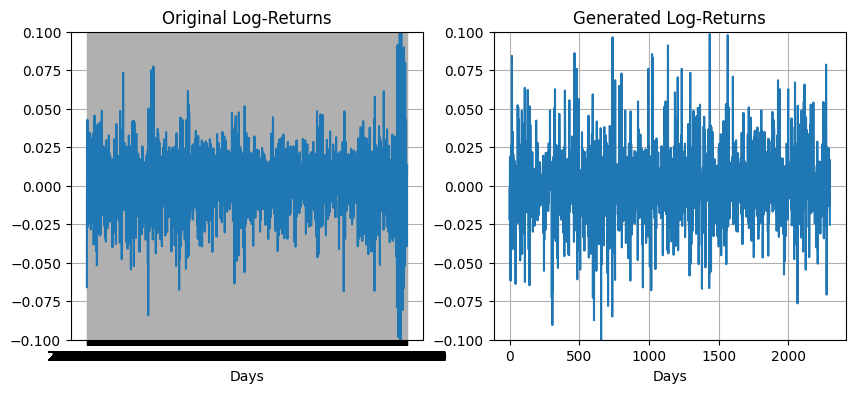

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot original log-returns on the left and the generated on the right
#
###################################################################################################################
axes[0].plot(date[1:], sp500_log_r_tf)
axes[0].set_xlabel('Days')
axes[0].set_title('Original Log-Returns')
axes[0].grid()
axes[0].set_ylim([-0.1, 0.1])


axes[1].plot(fake_original)
axes[1].set_xlabel('Days')
axes[1].set_title('Generated Log-Returns')
axes[1].grid()
axes[1].set_ylim([-0.1, 0.1])
plt.show()

In [32]:
df = pd.DataFrame(fake_original)

# Save the DataFrame to a CSV file
csv_filename = 'fake_original_BRAZIL_1.csv'
df.to_csv(csv_filename, index=False)

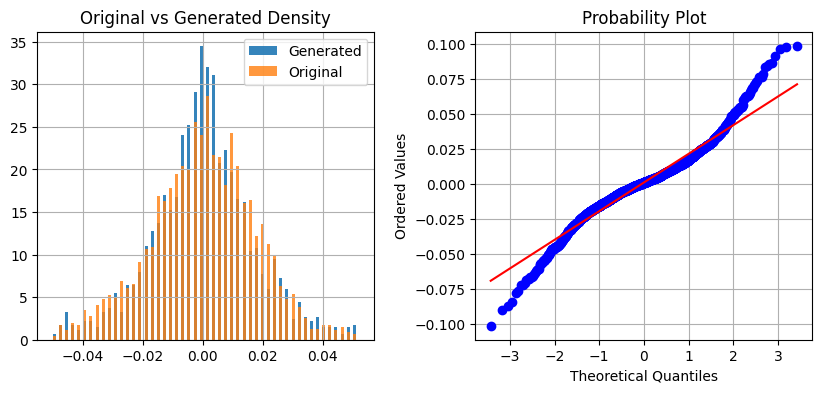

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot histogram of generated along with original log-returns on the left and the Q-Q plot on the right
#
###################################################################################################################
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(fake_original, bins=bin_edges, density=True, width=0.001, label='Generated', alpha=0.9)
axes[0].hist(sp500_log_r_tf, bins=bin_edges, density=True, width=0.001, label='Original', alpha=0.8)
axes[0].set_title('Original vs Generated Density')
axes[0].grid()
axes[0].legend()

probplot(fake_original, dist='norm', plot=axes[1])
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].grid()

plt.subplots_adjust(wspace=0.3)

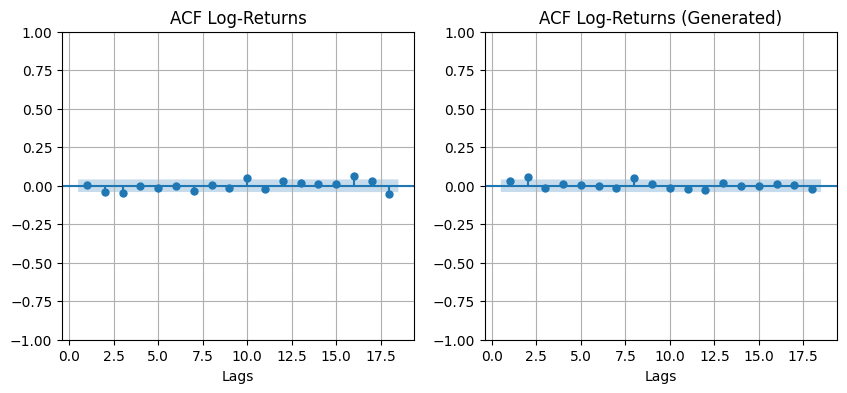

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot autocorrelations of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(sp500_log_r_tf, ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Log-Returns')
axes[0].grid()

tsaplots.plot_acf(fake_original, ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Log-Returns (Generated)')
axes[1].grid()

plt.show()

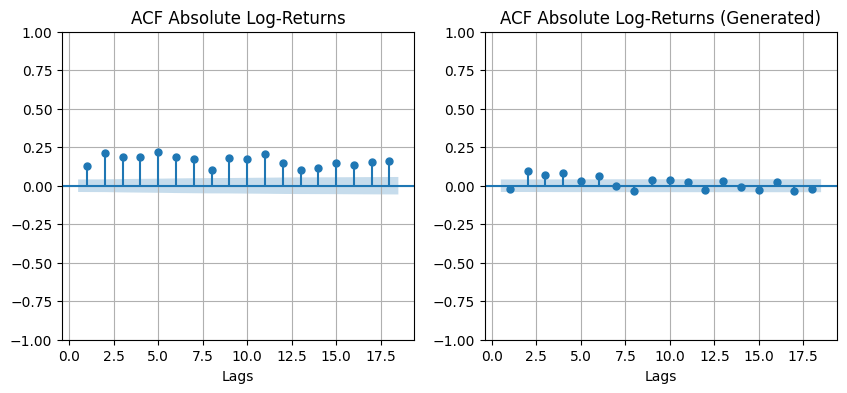

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot volatility clustering of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(tf.abs(sp500_log_r_tf), ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Absolute Log-Returns')
axes[0].grid()

tsaplots.plot_acf(tf.abs(fake_original), ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Absolute Log-Returns (Generated)')
axes[1].grid()

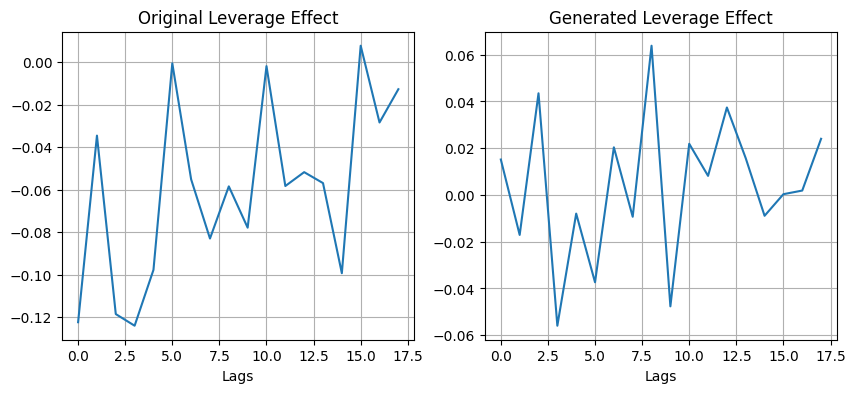

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot leverage effect of original log-returns on the left and the generated on the right
#
###################################################################################################################
# compute leverage effect for maximum lags = 18
leverage_original = []
for lag in range(1, 19):
    # slice the tensors to get the appropriate lagged sequences
    r_t = sp500_log_r_tf[:-lag]
    squared_lag_r = tf.square(tf.abs(sp500_log_r_tf[lag:]))

    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    leverage_original.append(correlation_matrix[0, 1])

leverage_generated = []
for lag in range(1, 19):
    # slice the tensors to get the appropriate lagged sequences
    r_t = fake_original[:-lag]
    squared_lag_r = tf.square(tf.abs(fake_original[lag:]))

    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    leverage_generated.append(correlation_matrix[0, 1])

axes[0].plot(leverage_original)
axes[0].set_xlabel('Lags')
axes[0].set_title('Original Leverage Effect')
axes[0].grid()

axes[1].plot(leverage_generated)
axes[1].set_xlabel('Lags')
axes[1].set_title('Generated Leverage Effect')
axes[1].grid()